# N=4 Average and deviation std of the models for the MSE (mean square error)
I make it because I hope the N=4 has the worst performance for the half structures

In Fldzhyan say that seem N lower matrix reproducible are not ALL

MORE INFLUENCE FROM THE SIDE OF THE CIRCUIT

In [1]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Compute MSE
def CMatrixMSELoss(target_matrix, predicted_matrix):
    mag_diff_sq = np.abs(predicted_matrix - target_matrix)**2
    loss = np.sum(mag_diff_sq) / np.size(target_matrix)
    return loss

In [3]:
# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

In [4]:
# Derive the MSE for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_MSE_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.extend([CMatrixMSELoss(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    loss_pd = pd.DataFrame({'label': labels, 'value': loss})
    return loss_pd

In [5]:
# Take best result MINIMUM value repetition
def models_repmin_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find min
    min_lastLoss_s = df.groupby('label_no_rep')['value'].min()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = min_lastLoss_s[min_lastLoss_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models

# SAVE everything
[(simulation hyp, name model, average, deviation std)]

In [6]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        mse_pd = derive_MSE_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmin_mean_devstd(mse_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/run_ave_dev_save.npy', ave_devstd_run_nparray)

## Plain comparison all the model

In [7]:
# Extrat the iloss and imb from the simulation label
def extract_values(label):
    match = re.search(r'iloss([-+]?[0-9]*\.?[0-9]+)_imb([-+]?[0-9]*\.?[0-9]+)', label)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

## Grpath positive and negative imbalance

### Difference between the Clements, Fldzhyan and the Bell version

Noting they seems the exact same. Some very very small variation due to calculation

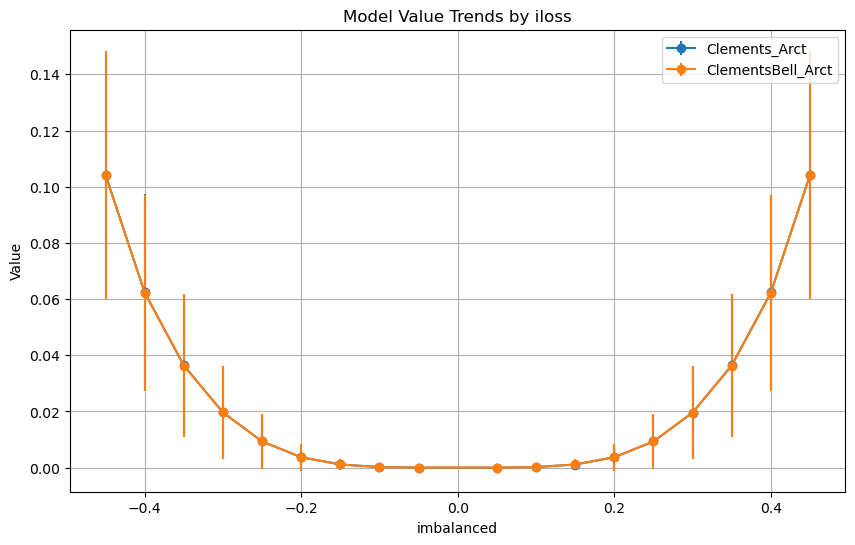

In [8]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_select = ['Clements_Arct', 'ClementsBell_Arct',]

plt.figure(figsize=(10, 6))
heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models_select:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    plt.errorbar(ave_devstd_filtered_model_df["imb"], ave_devstd_filtered_model_df["average"], yerr=ave_devstd_filtered_model_df["std_dev"],
                 marker='o', label=name_model)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

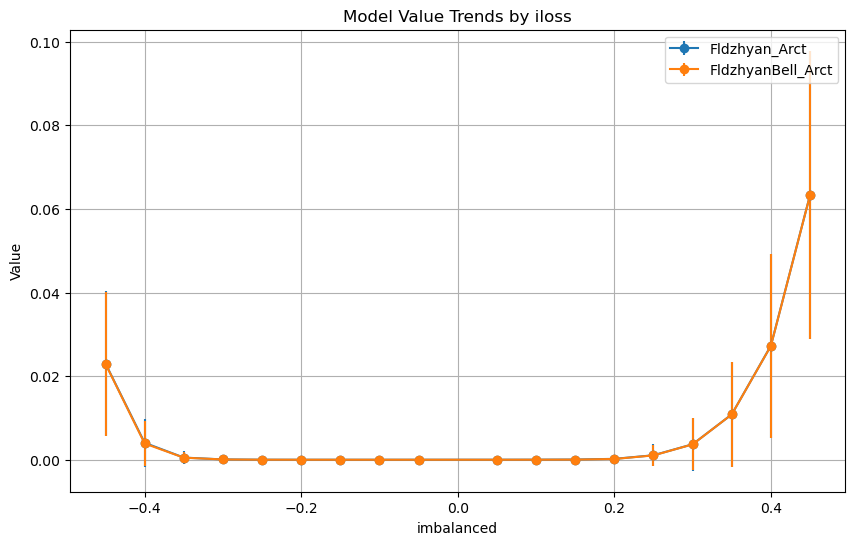

In [51]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_select = ['Fldzhyan_Arct', 'FldzhyanBell_Arct',]

plt.figure(figsize=(10, 6))
heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models_select:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    plt.errorbar(ave_devstd_filtered_model_df["imb"], ave_devstd_filtered_model_df["average"], yerr=ave_devstd_filtered_model_df["std_dev"],
                 marker='o', label=name_model)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

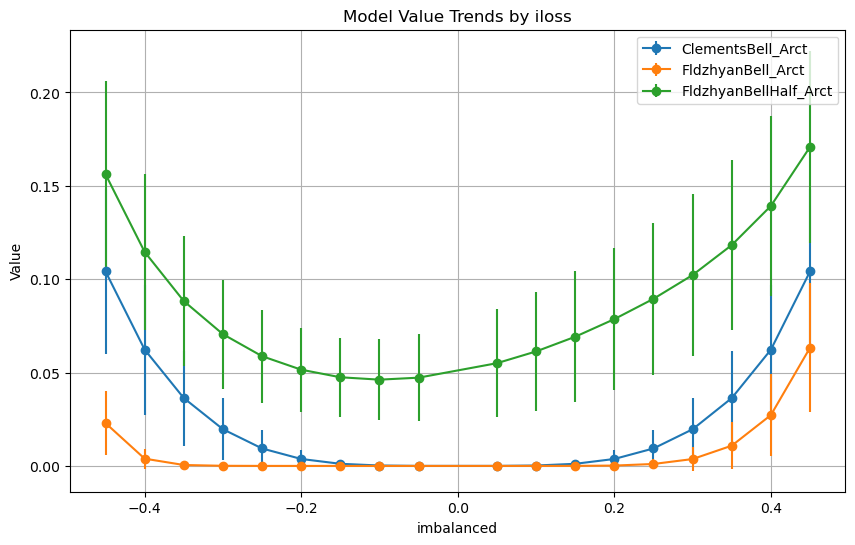

In [9]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_select = ['ClementsBell_Arct', 'FldzhyanBell_Arct',
                      'FldzhyanBellHalf_Arct',]

plt.figure(figsize=(10, 6))
heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models_select:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    plt.errorbar(ave_devstd_filtered_model_df["imb"], ave_devstd_filtered_model_df["average"], yerr=ave_devstd_filtered_model_df["std_dev"],
                 marker='o', label=name_model)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## NEUROPULS architecture 

Neuropuuls N-1 perform worst compare Clements for low vaalue of imbalanced

REMEMBER tha NEURPULS has cross talk = abs(imbalance) so also cross talk influence result!!!!!!!!

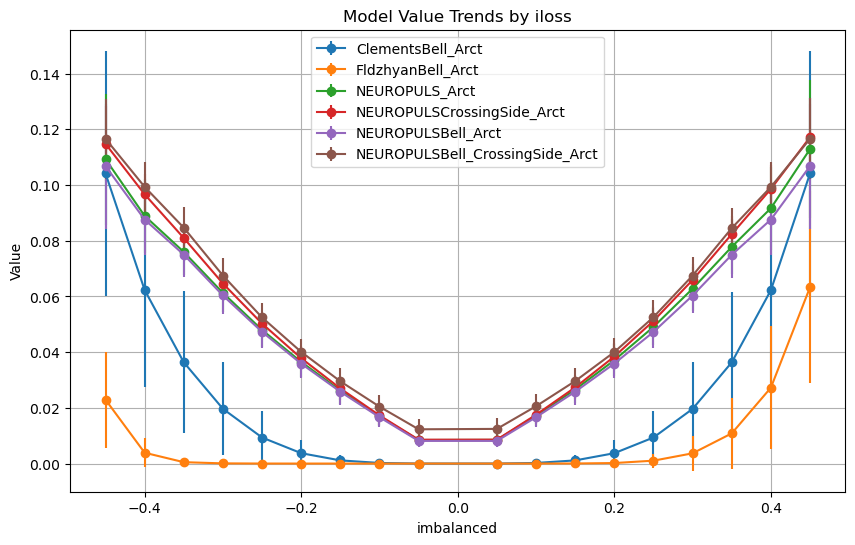

In [10]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_select = ['ClementsBell_Arct', 'FldzhyanBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',]

plt.figure(figsize=(10, 6))
heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models_select:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    plt.errorbar(ave_devstd_filtered_model_df["imb"], ave_devstd_filtered_model_df["average"], yerr=ave_devstd_filtered_model_df["std_dev"],
                 marker='o', label=name_model)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Seems the worst are the CossingSide version that is slitly worst

## Fldzhyan Half compare the NEUROPULS half

The neuropuls half perform slightly worst with 0 imb. And a little better when there is imbalance

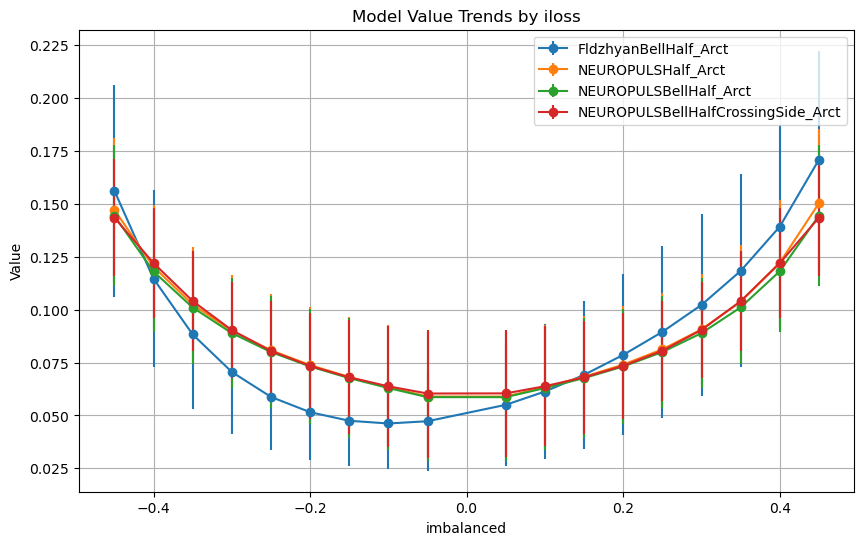

In [11]:
directory_run = 'outdata/20240603_run_N4'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_select = ['FldzhyanBellHalf_Arct',
                      'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

plt.figure(figsize=(10, 6))
heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models_select:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    plt.errorbar(ave_devstd_filtered_model_df["imb"], ave_devstd_filtered_model_df["average"], yerr=ave_devstd_filtered_model_df["std_dev"],
                 marker='o', label=name_model)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()